In [1]:
from glob import glob
from tqdm import tqdm
from time import time
import logging
import os

import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import random_split

from model import Unet
from dataset import ImageDataset

/usr/local/lib/python3.6/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [20]:
BATCH_SIZE = 32
EPOCHS = 10
LR = 0.00001

In [3]:
checkpoints_path = '/home/workspace/iot_ai_model/check_points/unet'

In [4]:
data_path = '/home/workspace/iot_ai_model/dataset/supervisely_person'

In [5]:
paths = glob(os.path.join(data_path,"**/*.png"))

In [6]:
logger = logging.getLogger()
logger.setLevel(logging.INFO)
formatter = logging.Formatter('%(asctime)s - %(message)s')
stream_handler = logging.StreamHandler()
stream_handler.setFormatter(formatter)
logger.addHandler(stream_handler)

In [7]:
dataset = ImageDataset(data_path)

images Loading: 2667it [01:12, 36.59it/s] 
masks Loading: 2667it [00:38, 68.95it/s] 


In [8]:
dataset_size = len(dataset)
trn_size = int(dataset_size * 0.8)
val_size = dataset_size - trn_size
trn_ds, val_ds = random_split(dataset, [trn_size, val_size])
trn_loader = torch.utils.data.DataLoader(trn_ds, batch_size= BATCH_SIZE, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_ds, batch_size= BATCH_SIZE, shuffle=False)
logger.info(f'trn: {len(trn_ds)}, val: {len(val_ds)}')    

2022-10-04 03:15:35,959 - trn: 2133, val: 534


In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
logger.info(f'Load on {device}')

2022-10-04 03:15:36,688 - Load on cuda


In [10]:
model = Unet().to(device)
params_cnt = sum(p.numel() for p in model.parameters() if p.requires_grad)
logger.info(f'loaded model (params {params_cnt})')

2022-10-04 03:15:39,237 - loaded model (params 5685495)


In [11]:
class DiceLoss(nn.Module):
    def __init__(self):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        # inputs[inputs > 0.5] = 1
        # inputs[inputs <= 0.5] = 0
        # inputs = F.sigmoid(inputs) # sigmoid를 통과한 출력이면 주석처리
        
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice = (2.*intersection + smooth) / (inputs.sum() + targets.sum() + smooth)  
        
        return 1 - dice 

In [12]:
criterion1 = DiceLoss()
criterion2 = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr = LR)

In [13]:
def fit(model, dataloader, criterion1, criterion2, optimizer, device, half = False):
    cost = .0
    acc = .0
    correct = 0
    start_time = time()
    
    progress = tqdm(dataloader)
    for path, data, target in progress:
        data = data.to(device).type(torch.float32)
        target = target.to(device).type(torch.float32)
        
        output = model(data)
        
        loss1 = criterion1(output, target)
        loss2 = criterion2(output, target)
        
        loss = loss1 + loss2
        
        if model.training:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        cost += loss.cpu().item()

    # acc = (correct/len(dataloader.dataset))
    loss = loss/len(dataloader)
    logger.info("{}, duration:{:6.1f}s, loss:{:.4f}".format(('trn' if model.training else 'val'), 
                                                                         time()-start_time, 
                                                                         loss ))
    return float(loss)

In [14]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

In [15]:
def get_random_data(dataset):
    id = np.random.randint(len(dataset))
    path, image, mask = dataset[id]
    return image, mask

In [16]:
def convert_tensor_to_img(tensor):
    img = tensor.cpu().detach().numpy()
    img = np.transpose(img, (1,2,0))
    return img
    
def convert_img_to_tensor(img, device = 'cpu'):
    return torch.tensor(img.reshape(1,3,256,256)).to(device)

In [17]:
def show_image(image, alpha=1, title=None):
    plt.imshow(image, alpha=alpha)
    plt.title(title)
    plt.axis('off')

In [18]:
def show_predictions(model, dataset, n_images=1):
    for i in range(n_images):
        plt.figure(figsize=(10,8))
        
        img, mask = get_random_data(dataset)
        tensor = convert_img_to_tensor(img, device= device)
        pred_mask = model(tensor)
        
        plt.subplot(1,3,1)
        img = np.transpose(img, (1,2,0))
        show_image(img, title='Original Image')
        
        plt.subplot(1,3,2)
        mask = np.transpose(mask, (1,2,0))
        show_image(mask, title='Original Mask')
        
        plt.subplot(1,3,3)
        pred_img = convert_tensor_to_img(pred_mask[0])
        show_image(pred_img, title='Predicted Mask')
        
        plt.show()

In [19]:
model_path = f"{checkpoints_path}/model_state_dict_latest.pt"
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

2022-10-04 03:16:07,838 - epoch 1
100%|██████████| 67/67 [00:20<00:00,  3.21it/s]
2022-10-04 03:16:28,855 - trn, duration:  20.9s, loss:0.0061
100%|██████████| 17/17 [00:01<00:00, 10.12it/s]
2022-10-04 03:16:30,602 - val, duration:   1.7s, loss:0.0122
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys


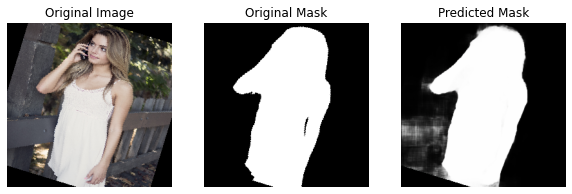

2022-10-04 03:16:30,743 - epoch 2
100%|██████████| 67/67 [00:21<00:00,  3.18it/s]
2022-10-04 03:16:51,899 - trn, duration:  21.0s, loss:0.0045
100%|██████████| 17/17 [00:01<00:00, 10.06it/s]
2022-10-04 03:16:53,656 - val, duration:   1.7s, loss:0.0127


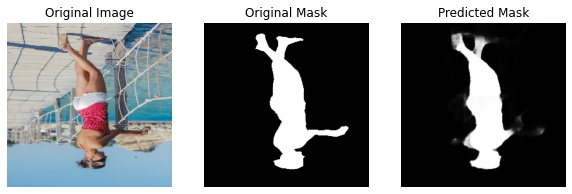

2022-10-04 03:16:53,786 - epoch 3
 24%|██▍       | 16/67 [00:05<00:16,  3.02it/s]


KeyboardInterrupt: 

In [21]:
trn_loss = []
val_loss = []

half = False

min_loss = 99999.
early_count = 0
for epoch in range(1, EPOCHS+1):
    logger.info(f'epoch {epoch}')

    model.train()
    loss = fit(model, trn_loader, criterion1, criterion2, optimizer, device, half=half)

    trn_loss.append(loss)

    model.eval()
    with torch.no_grad():
        loss = fit(model, val_loader, criterion1, criterion2, optimizer, device, half=half)

        # if loss >= min_loss:
        #     early_count += 1
        #     if early_count >= early_stopping:
        #         break
        # else:
        #     min_loss = loss
        #     early_count = 0

        if len(val_loss) > 0 and min(val_loss) > loss:
            torch.save(model.state_dict(), f"{checkpoints_path}/model_state_dict_{epoch}_best.pt")

        val_loss.append(loss)
    
    show_predictions(model, val_ds)

torch.save(model.state_dict(), f"{checkpoints_path}/model_state_dict_{epoch}.pt")

In [25]:
with open('/home/workspace/iot_ai_model/dataset/supervisely_person/test_data_list.txt', 'w') as f:
    for idx, (filename, _, _) in enumerate(val_ds):
        f.write('{},{}\n'.format(filename.replace('/home/workspace/iot_ai_model/dataset/supervisely_person/', ''), val_ds.dataset.mask_path[idx]))

In [34]:
import base64

In [31]:
n = np.zeros((3,256,256))

In [35]:
s = base64.b64encode(n)

In [36]:
len(s)

2097152